In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from nlgcg_parameter_free import NLGCGParameterFree

# Heat Equation

## Generate Data and Define Functions

In [17]:
Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [18]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [19]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [20]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [21]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [22]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [23]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [24]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [25]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [26]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [27]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [28]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

## Experiments

In [29]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           global_search_resolution=100
           )

In [30]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-12, max_radius=0.1)

INFO:root:Radii: []
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05000000000000001, objective: 2.590E+01, dropped: False
INFO:root:=====================================================
INFO:root:Radii: [0.1]
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.136E+00
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:norm_grad: 1.2896713015087883e-05, constant: 0.0007004139746575969, diff: -2.859934511434403e-13
INFO:root:1, 4: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:Inequalities 6.6: [True, True, False]
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:2: choice: 3, lazy: True, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00, dro

In [31]:
np.array(times)

array([0.        , 0.01204395, 0.02545643, 0.03215003, 0.03875518,
       0.04372096, 0.05446172, 0.06473422, 0.07105565, 0.07602715,
       0.08226085, 0.08867455, 0.10237122, 0.11852384, 0.13324094,
       0.14919877, 0.16492486, 0.18044114, 0.19771075, 0.21371675,
       0.23277092, 0.24938536, 0.27006674, 0.28679919, 0.30874515,
       0.3274641 , 0.34912372, 0.81385946, 0.83357477, 0.84907317,
       0.87346268, 0.89088488, 0.91259503, 0.92007852, 1.40022182,
       1.41772151, 1.42512131, 1.4322865 , 1.43973422, 1.44962716,
       1.45643258, 1.47325921, 1.49498153, 1.50166321, 1.50671816,
       1.51191592, 1.52055335, 1.5255754 , 1.53210545, 1.53739405,
       2.00195527, 2.0071106 , 2.44165015])

In [19]:
u.coefficients

array([ 0.99569143, -0.6175807 ,  0.71213226])

In [20]:
u.support

array([[0.28322727, 0.71433132],
       [0.49565837, 0.23548621],
       [0.73058833, 0.54790134]])

In [31]:
dropped_tot

0

## Plots

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7fda88a58760>


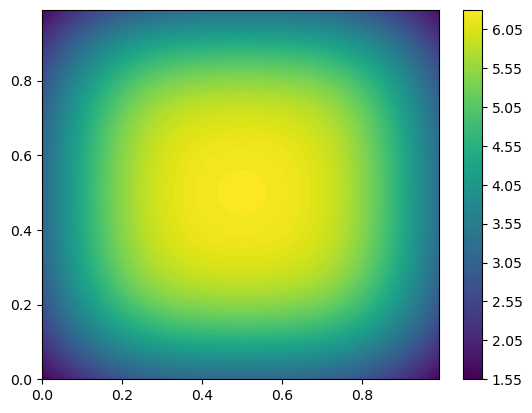

In [18]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
p_u = p(u_tilde)
fct = lambda x: np.linalg.norm(kappa(x), axis=1)
a = np.arange(0,1,0.01)
x, y = np.meshgrid(a,a)
points = np.array(list(zip(x.flatten(), y.flatten())))
vals = fct(points).reshape((100,100))

plt.contourf(x, y, vals, levels=100);
plt.colorbar();

# Signal Processing

## Generate Data and Define Functions

In [2]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [3]:
observations = np.arange(0,1,1/observation_resolution)

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

## Experiments

In [14]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           global_search_resolution=1000
           )

In [15]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-12, max_radius=1)

INFO:root:Radii: []
DEBUG:root:SSN in 1 dimensions converged in 2 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05, objective: 5.291E+01, dropped: False
INFO:root:=====================================================
INFO:root:Radii: [1]
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:gap: 1.6468758756419227e-11, norm grad: 1.1518566082051635e-11
INFO:root:gap: 1.6468758756419227e-11, norm grad: 1.1518566082051635e-11
INFO:root:1, 4: lazy: True, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:Inequality 6.7: False
DEBUG:root:SSN in 3 dimensions converged in 5 iterations to tolerance 5.000E-04
INFO:root:2: choice: 4, lazy: True, support: 2, epsilon: 0.05, objective: 7.911E+00, dropped: False
INFO:root:==============================================

In [16]:
np.array(times)

array([2.38418579e-07, 1.95789337e-02, 4.32834625e-02, 5.58636189e-02,
       6.96122646e-02, 8.52971077e-02, 1.06263638e-01, 1.36299133e-01,
       1.50459766e-01, 1.60699368e-01, 3.00843000e-01, 5.21606445e-01])

In [18]:
dropped_tot

0

In [19]:
u.coefficients

array([-0.99832728,  0.69841291,  0.49833707])

In [20]:
u.support

array([[ 3.12502173],
       [ 6.9999926 ],
       [13.37905649]])

## Plots

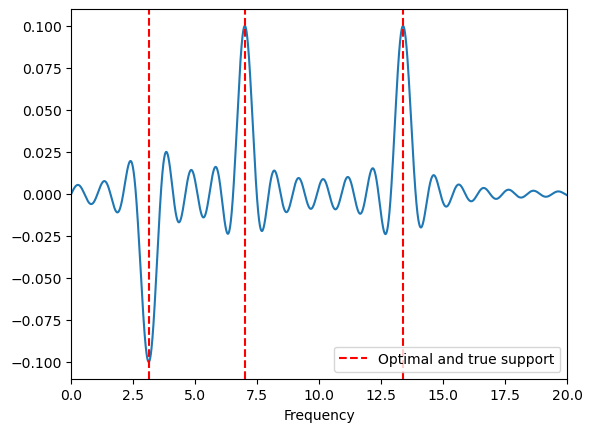

In [19]:
u_tilde = u # Newton solution
a = np.arange(Omega[0][0],Omega[0][1],0.005)
p_u = p(u_tilde)
vals = p_u(a)
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(-0.11,0.11);
plt.xlim(0, 20);
plt.legend();